In [1]:
import re
import numpy as np
import pandas as pd
from html import unescape
from scipy.stats import skew

In [2]:
df = pd.read_csv('data/data_kaggle.csv')

df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


In [3]:
# Remove 'RM" and convert to numeric
df['Price'] = df['Price'].str.replace('RM', '').str.replace(',', '').astype(float)
df['Price']

0        1250000.0
1        6800000.0
2        1030000.0
3              NaN
4         900000.0
           ...    
53878    5100000.0
53879    5000000.0
53880    5500000.0
53881     480000.0
53882     540000.0
Name: Price, Length: 53883, dtype: float64

In [4]:
# Only take the district name
df['Location'] = df['Location'].str.replace(', Kuala Lumpur', '').str.upper()

In [5]:
# Clean Rooms column
def clean_rooms(rooms):
    if pd.isna(rooms):
        return None
    match = re.match(r"(\d+)(\+(\d+))?", rooms)
    if match:
        main_rooms = int(match.group(1))
        additional_rooms = int(match.group(3)) if match.group(3) else 0
        return main_rooms + additional_rooms
    return None

df['Rooms'] = df['Rooms'].apply(clean_rooms)
df['Rooms']

0        3.0
1        6.0
2        3.0
3        NaN
4        5.0
        ... 
53878    6.0
53879    5.0
53880    6.0
53881    3.0
53882    4.0
Name: Rooms, Length: 53883, dtype: float64

In [6]:
# Update the Size extraction function to handle different formats
def extract_size(size):
    if pd.isna(size):
        return None

    # Convert special HTML entities to their corresponding symbols
    size = unescape(size)

    # Match width x length (with optional area in parentheses) format
    match = re.match(r".*?(\d+)\s*[xX'\*]\s*(\d+)\s*\((\d+)\s*sf\).*", size)
    if match:
        return int(match.group(3))

    match = re.match(r".*?(\d+)\s*[xX'\*]\s*(\d+).*", size)
    if match:
        width = int(match.group(1))
        length = int(match.group(2))
        return width * length

    # Match range format and take the average
    match = re.match(r".*?(\d+)\s*[-~]\s*(\d+).*", size)
    if match:
        low = int(match.group(1))
        high = int(match.group(2))
        return (low + high) / 2

    # Match single numeric value
    match = re.search(r"(\d[\d,]*)\s*sq\.?\s*ft\.?", size)
    if match:
        return int(match.group(1).replace(',', ''))

    return None

df['Size'] = df['Size'].apply(extract_size)
df['Size']

0         1335.0
1         6900.0
2         1875.0
3            NaN
4         1513.0
          ...   
53878     7168.0
53879    15000.0
53880     7168.0
53881     1150.0
53882     1313.0
Name: Size, Length: 53883, dtype: float64

In [7]:
df.isna().sum()

Location             0
Price              248
Rooms             2580
Bathrooms         2013
Car Parks        17567
Property Type       25
Size              1345
Furnishing        6930
dtype: int64

In [8]:
df['Size'].value_counts()

1650.0      971
1400.0      633
1100.0      590
950.0       523
1760.0      518
           ... 
5228.0        1
14897.0       1
248292.0      1
4212.0        1
6050.0        1
Name: Size, Length: 4099, dtype: int64

In [9]:
# Fill missing values with median for numeric columns
df['Rooms'] = df['Rooms'].fillna(df['Rooms'].median())
df['Bathrooms'] = df['Bathrooms'].fillna(df['Bathrooms'].median())

# Drop missing values for Size and Price
df.dropna(subset=['Size'], inplace=True)
df.dropna(subset=['Price'])

# Fill missing Car Parks with 0
df['Car Parks'] = df['Car Parks'].fillna(0)

# Fill missing and Unknown Furnishing with 'Unfurnished'
df['Furnishing'] = df['Furnishing'].fillna('Unfurnished')
df['Furnishing'] = df['Furnishing'].replace('Unknown', 'Unfurnished')

In [10]:
# Generalize Property Type
def generalize_property_type(property_type):
    if pd.isna(property_type):
        return None
    
    # General property types
    mappings = {
        "1-sty Terrace/Link House": "1-sty Terrace/Link House",
        "1.5-sty Terrace/Link House": "1.5-sty Terrace/Link House",
        "2-sty Terrace/Link House": "2-sty Terrace/Link House",
        "2.5-sty Terrace/Link House": "2.5-sty Terrace/Link House",
        "3-sty Terrace/Link House": "3-sty Terrace/Link House",
        "3.5-sty Terrace/Link House": "3.5-sty Terrace/Link House",
        "4-sty Terrace/Link House": "4-sty Terrace/Link House",
        "4.5-sty Terrace/Link House": "4.5-sty Terrace/Link House",
        "Serviced Residence": "Serviced Residence",
        "Condominium": "Condominium",
        "Bungalow": "Bungalow",
        "Townhouse": "Townhouse",
        "Semi-detached House": "Semi-detached House",
        "Apartment": "Apartment",
        "Studio": "Studio",
        "Flat": "Flat",
        "Cluster House": "Cluster House",
        "Residential Land": "Residential Land"
    }
    
    for key in mappings:
        if key in property_type:
            return mappings[key]
    return property_type

df['Property Type'] = df['Property Type'].apply(generalize_property_type)
df['Property Type'].unique()

array(['Serviced Residence', 'Bungalow', 'Condominium',
       'Semi-detached House', '2-sty Terrace/Link House', 'Apartment',
       '3-sty Terrace/Link House', '2.5-sty Terrace/Link House',
       '3.5-sty Terrace/Link House', '1-sty Terrace/Link House',
       '1.5-sty Terrace/Link House', '4-sty Terrace/Link House',
       'Townhouse', 'Residential Land', '4.5-sty Terrace/Link House',
       'Flat', 'Cluster House'], dtype=object)

In [11]:
df['Property Type'].value_counts()

Condominium                   22827
Serviced Residence            13098
2-sty Terrace/Link House       4078
Bungalow                       3679
Semi-detached House            2124
3-sty Terrace/Link House       1656
Apartment                      1632
1-sty Terrace/Link House        799
2.5-sty Terrace/Link House      709
Residential Land                661
Townhouse                       537
Flat                            363
3.5-sty Terrace/Link House      188
1.5-sty Terrace/Link House       97
4-sty Terrace/Link House         57
4.5-sty Terrace/Link House       24
Cluster House                     9
Name: Property Type, dtype: int64

In [12]:
# Filter out rare property types with less than 100 instances
property_type_counts = df['Property Type'].value_counts()
rare_property_types = property_type_counts[property_type_counts < 200].index
df = df[~df['Property Type'].isin(rare_property_types)]

In [13]:
df['Property Type'].value_counts()

Condominium                   22827
Serviced Residence            13098
2-sty Terrace/Link House       4078
Bungalow                       3679
Semi-detached House            2124
3-sty Terrace/Link House       1656
Apartment                      1632
1-sty Terrace/Link House        799
2.5-sty Terrace/Link House      709
Residential Land                661
Townhouse                       537
Flat                            363
Name: Property Type, dtype: int64

In [14]:
df['Furnishing'].value_counts()

Partly Furnished    25883
Fully Furnished     13656
Unfurnished         12624
Name: Furnishing, dtype: int64

Outliers detected in Price using Z-Score method: 41
Outliers detected in Rooms using Z-Score method: 191
Outliers detected in Size using Z-Score method: 27
Outliers detected in Price using IQR method: 4926
Outliers detected in Rooms using IQR method: 8020
Outliers detected in Size using IQR method: 5499


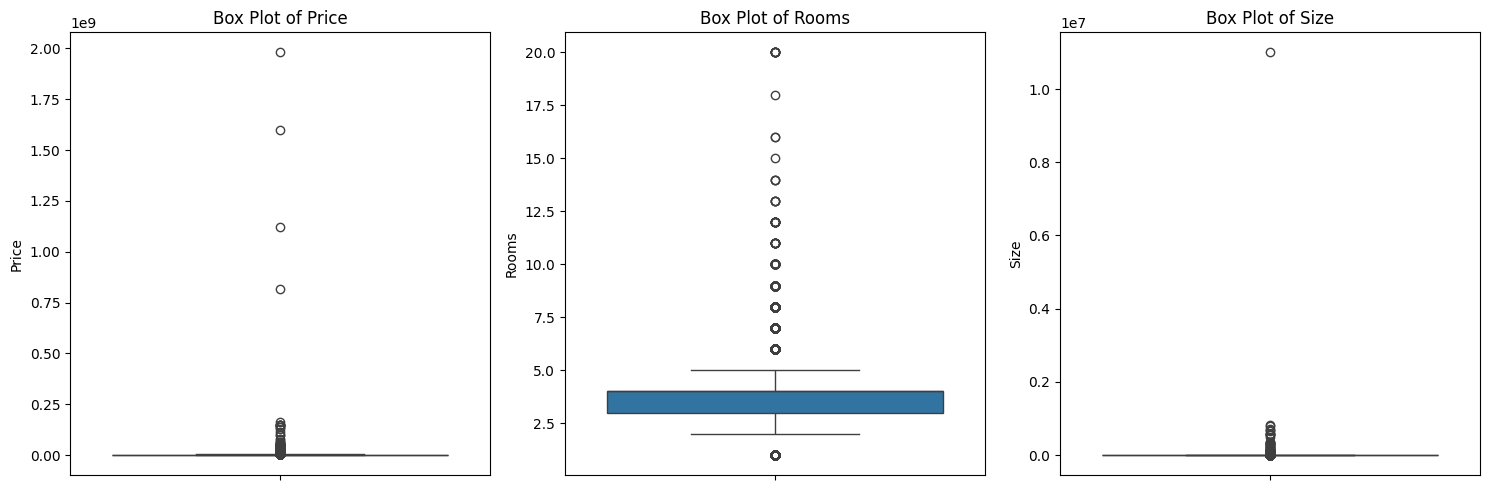

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Detect outliers using Z-Score
def detect_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    return np.where(np.abs(z_scores) > threshold)

# Detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((data < lower_bound) | (data > upper_bound))

# Columns to check for outliers
numeric_columns = ['Price', 'Rooms', 'Size']

# Z-Score method
for col in numeric_columns:
    outliers_zscore = detect_outliers_zscore(df[col].dropna())
    print(f'Outliers detected in {col} using Z-Score method: {len(outliers_zscore[0])}')

# IQR method
for col in numeric_columns:
    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f'Outliers detected in {col} using IQR method: {len(outliers_iqr[0])}')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Outliers remaining in Price using Z-Score method: 0
Outliers remaining in Price using IQR method: 4827
Outliers remaining in Rooms using Z-Score method: 0
Outliers remaining in Rooms using IQR method: 0
Outliers remaining in Size using Z-Score method: 0
Outliers remaining in Size using IQR method: 0


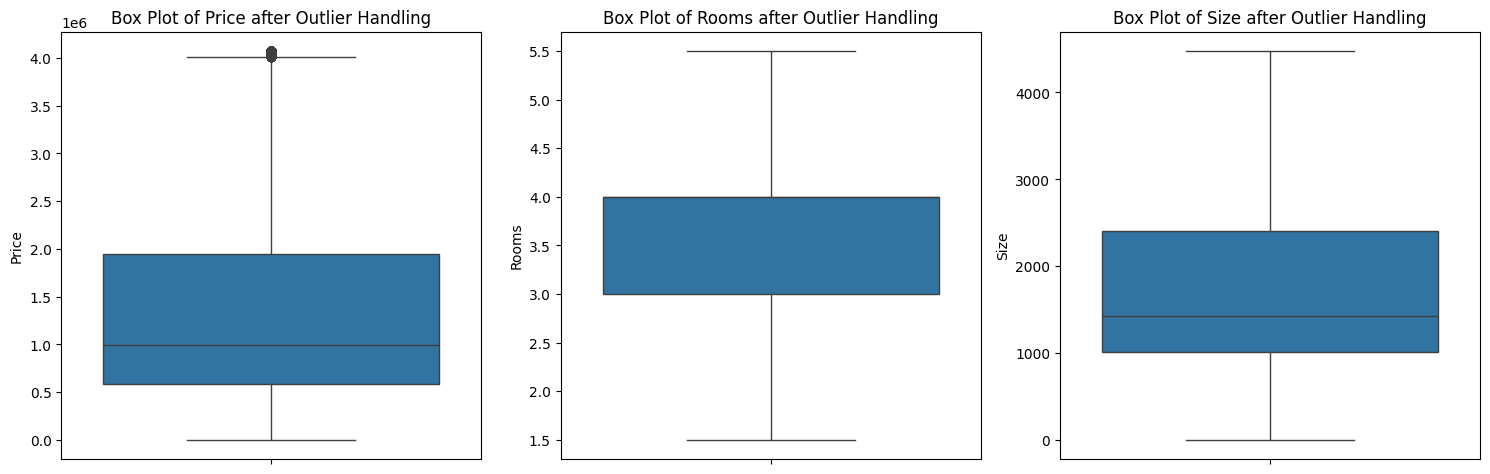

In [16]:
# Remove extreme outliers
def remove_extreme_outliers(df, col):
    outliers_zscore = set(detect_outliers_zscore(df[col].dropna())[0])
    outliers_iqr = set(detect_outliers_iqr(df[col].dropna())[0])
    extreme_outliers = outliers_zscore.intersection(outliers_iqr)
    return df.drop(index=df.iloc[list(extreme_outliers)].index)

# Cap remaining outliers to IQR bounds
def cap_outliers(df, col):
    Q1 = np.percentile(df[col].dropna(), 25)
    Q3 = np.percentile(df[col].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

for col in numeric_columns:
    df = remove_extreme_outliers(df, col)
    df = cap_outliers(df, col)

# Verify the changes 
for col in numeric_columns:
    outliers_zscore = detect_outliers_zscore(df[col].dropna())
    outliers_iqr = detect_outliers_iqr(df[col].dropna())
    print(f'Outliers remaining in {col} using Z-Score method: {len(outliers_zscore[0])}')
    print(f'Outliers remaining in {col} using IQR method: {len(outliers_iqr[0])}')

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col} after Outlier Handling')
plt.tight_layout()
plt.show()

In [17]:
df[df['Price'] < 100000]

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
922,KLCC,1800.0,4.0,1.0,0.0,Serviced Residence,493.0,Partly Furnished
923,KLCC,1800.0,4.0,1.0,0.0,Serviced Residence,493.0,Partly Furnished
1196,KLCC,7500.0,2.0,2.0,1.0,Serviced Residence,1078.0,Fully Furnished
1878,BUKIT BINTANG,3000.0,1.5,1.0,1.0,Condominium,538.0,Fully Furnished
2549,KLCC,8000.0,5.0,5.0,0.0,Serviced Residence,2096.0,Fully Furnished
...,...,...,...,...,...,...,...,...
52928,SRI PETALING,1500.0,3.0,2.0,1.0,Condominium,850.0,Partly Furnished
52935,SRI PETALING,1100.0,3.0,2.0,1.0,Condominium,850.0,Partly Furnished
52996,BANGSAR,3500.0,4.0,3.0,1.0,Condominium,1300.0,Fully Furnished
53095,MONT KIARA,4000.0,4.0,1.0,0.0,Serviced Residence,1540.0,Fully Furnished


In [18]:
df = df[df['Price'] >= 100000]
df[df['Price'] < 100000]

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing


In [19]:
df[df['Size'] < 400]

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
583,MONT KIARA,2340000.0,5.0,5.0,3.0,Condominium,0.0,Partly Furnished
584,MONT KIARA,1698000.0,4.0,4.0,2.0,Condominium,0.0,Partly Furnished
1473,KL CITY,319999.0,4.0,1.0,0.0,Serviced Residence,351.0,Fully Furnished
1867,TAMAN DESA,1450000.0,4.0,3.0,2.0,2-sty Terrace/Link House,85.0,Unfurnished
1881,DAMANSARA HEIGHTS,4072500.0,5.5,4.0,0.0,Bungalow,55.0,Partly Furnished
...,...,...,...,...,...,...,...,...
53191,DESA PARKCITY,1350000.0,4.0,3.0,2.0,Condominium,0.0,Partly Furnished
53193,DESA PARKCITY,1480000.0,4.0,3.0,2.0,3-sty Terrace/Link House,0.0,Partly Furnished
53194,DESA PARKCITY,1600000.0,4.0,3.0,1.0,3-sty Terrace/Link House,0.0,Partly Furnished
53213,KL CITY,1550000.0,3.0,3.0,2.0,Serviced Residence,0.0,Fully Furnished


In [20]:
df = df[df['Size'] >= 450]
df[df['Size'] < 450]

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing


In [21]:
df.to_csv('data/cleaned_data.csv')

In [22]:
# Perform one-hot encoding on updated categorical variables
encoded_df = pd.get_dummies(df, columns=['Location', 'Property Type', 'Furnishing'], drop_first=False)

In [23]:
encoded_df

,Price,Rooms,Bathrooms,Car Parks,Size,Location_ADIVA DESA PARKCITY,Location_ALAM DAMAI,Location_AMPANG,Location_AMPANG HILIR,Location_BANDAR DAMAI PERDANA,...,Property Type_Bungalow,Property Type_Condominium,Property Type_Flat,Property Type_Residential Land,Property Type_Semi-detached House,Property Type_Serviced Residence,Property Type_Townhouse,Furnishing_Fully Furnished,Furnishing_Partly Furnished,Furnishing_Unfurnished
0,1250000.0,3.0,3.0,2.0,1335.0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,4072500.0,5.5,7.0,0.0,4477.5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1030000.0,3.0,4.0,2.0,1875.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,900000.0,5.0,3.0,2.0,1513.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
5,4072500.0,5.5,5.0,4.0,4477.5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53878,4072500.0,5.5,4.0,0.0,4477.5,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
53879,4072500.0,5.0,4.0,0.0,4477.5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
53880,4072500.0,5.5,4.0,0.0,4477.5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
53881,480000.0,3.0,2.0,0.0,1150.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [24]:
encoded_df.to_csv('data/encoded_data.csv', index=False)

In [25]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [26]:
X = encoded_df.drop(columns=['Price'])
y = encoded_df['Price']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model_train_score = linear_model.score(X_train, y_train)
linear_model_test_score = linear_model.score(X_test, y_test)
print(f"Linear Regression Training score: {linear_model_train_score}")
print(f"Linear Regression Testing score: {linear_model_test_score}")

# Cross-Validation for Linear Regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
linear_cv_scores = cross_val_score(linear_model, X, y, cv=kf, scoring='r2')
print(f"Linear Regression Cross-Validation scores: {linear_cv_scores}")
print(f"Linear Regression Cross-Validation Mean score: {np.mean(linear_cv_scores)}")

Linear Regression Training score: 0.8683020545891691
Linear Regression Testing score: 0.8628822526683546
Linear Regression Cross-Validation scores: [0.86288225 0.86733917 0.86428863 0.86727209 0.87025196]
Linear Regression Cross-Validation Mean score: 0.8664068183586082


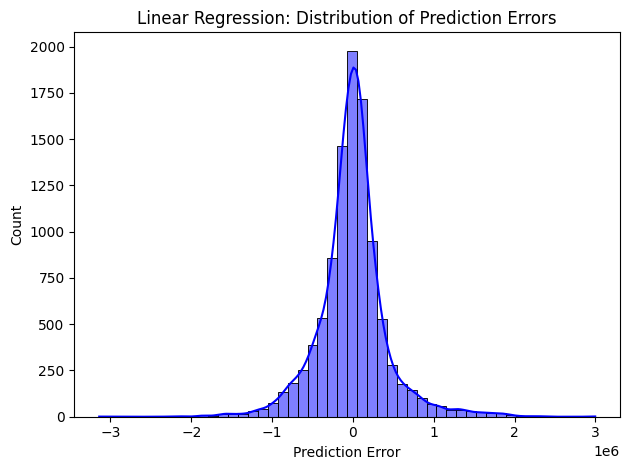

In [29]:
# Predictions
y_pred_linear = linear_model.predict(X_test)

errors_lr = y_test - y_pred_linear

sns.histplot(errors_lr, bins=50, kde=True, color='blue')
plt.xlabel("Prediction Error")
plt.title("Linear Regression: Distribution of Prediction Errors")

plt.tight_layout()
plt.show()

In [30]:
mae_lr = mean_absolute_error(y_test, y_pred_linear)
mse_lr = mean_squared_error(y_test, y_pred_linear)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_linear)

print("Linear Regression Performance:")
print(f"MAE: {mae_lr}")
print(f"MSE: {mse_lr}")
print(f"RMSE: {rmse_lr}")
print(f"R-squared: {r2_lr}")

Linear Regression Performance:
MAE: 290168.2889183051
MSE: 186405552652.16315
RMSE: 431747.09339167894
R-squared: 0.8628822526683546


In [31]:
# Random Forest Regressor Model
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

rf_model_train_score = rf_model.score(X_train_scaled, y_train)
rf_model_test_score = rf_model.score(X_test_scaled, y_test)

print(f"Random Forest training score: {rf_model_train_score}")
print(f"Random Forest testing score: {rf_model_test_score}")

Random Forest training score: 0.9831898994849854
Random Forest testing score: 0.9391420637862543


In [32]:
rf_cv_scores = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='r2')
print(f"Random Forest Cross-Validation scores: {rf_cv_scores}")
print(f"Random Forest Cross-Validation Mean score: {np.mean(rf_cv_scores)}")

Random Forest Cross-Validation scores: [0.93928963 0.94050332 0.94113998 0.94333932 0.94150993]
Random Forest Cross-Validation Mean score: 0.9411564351099505


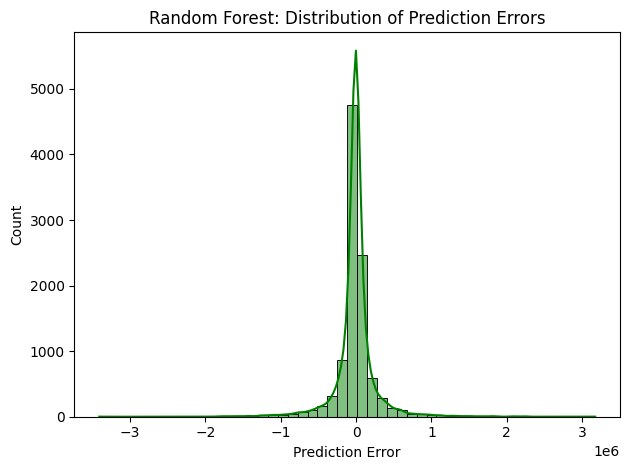

In [33]:
# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
errors_rf = y_test - y_pred_rf

sns.histplot(errors_rf, bins=50, kde=True, color='green')
plt.xlabel("Prediction Error")
plt.title("Random Forest: Distribution of Prediction Errors")

plt.tight_layout()
plt.show()

In [34]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"MAE: {mae_rf}")
print(f"MSE: {mse_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R-squared: {r2_rf}")


Random Forest Performance:
MAE: 144069.69577736457
MSE: 82733690233.0748
RMSE: 287634.64713604096
R-squared: 0.9391420637862543


In [35]:
# Fit the Random Forest model on the entire dataset
rf_model.fit(X_scaled, y)


RandomForestRegressor(random_state=42)

In [36]:
import matplotlib.pyplot as plt

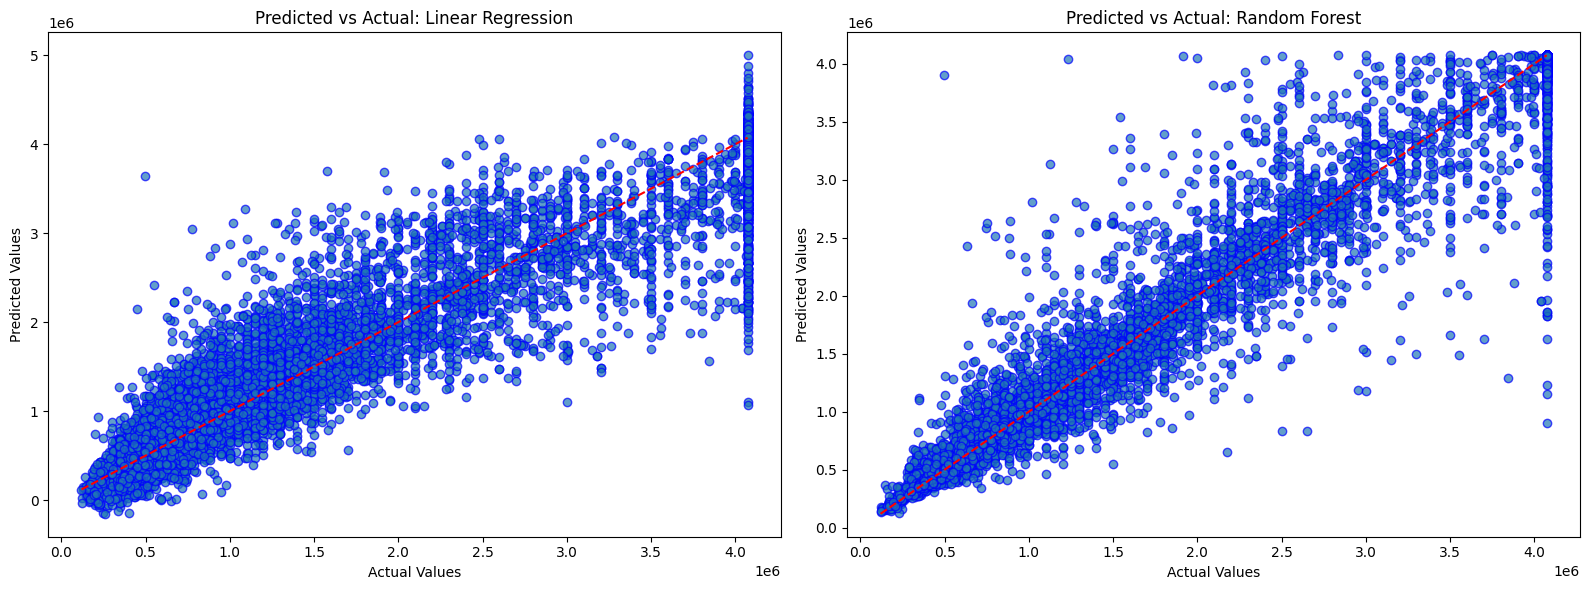

In [37]:
# Plotting Predicted vs Actual Values
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Linear Regression')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7, edgecolors='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual: Random Forest')

plt.tight_layout()
plt.show()

In [38]:
# Save the trained model and scaler
joblib.dump(rf_model, 'joblibs/rf_model.joblib')
joblib.dump(scaler, 'joblibs/scaler.joblib')
joblib.dump(X.columns, 'joblibs/feature_columns.joblib')

['joblibs/feature_columns.joblib']

In [39]:
import gzip
import shutil

# Compress model file
def compress_model(input_file, output_file):
    with open(input_file, 'rb') as f_in:
        with gzip.open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

compress_model('joblibs/rf_model.joblib', 'joblibs/rf_model.joblib.gz')

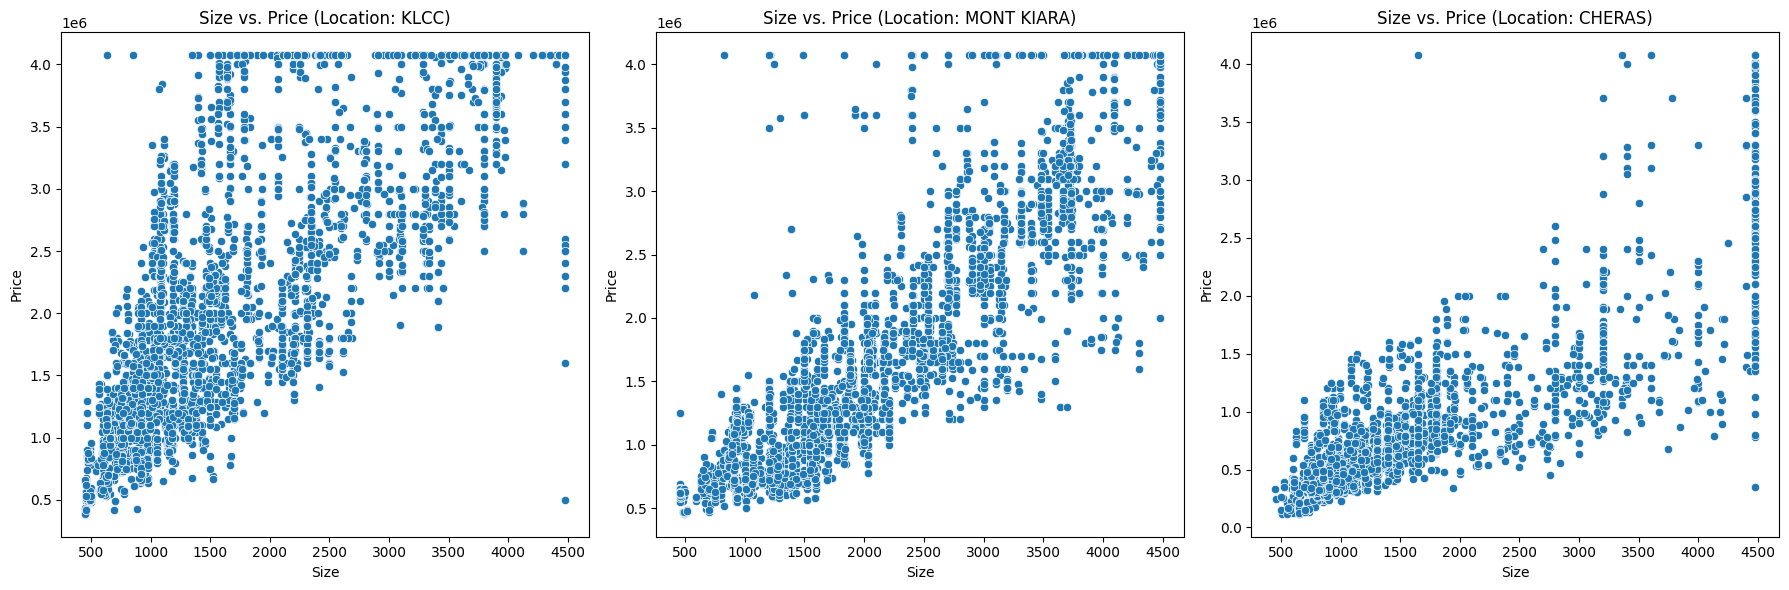

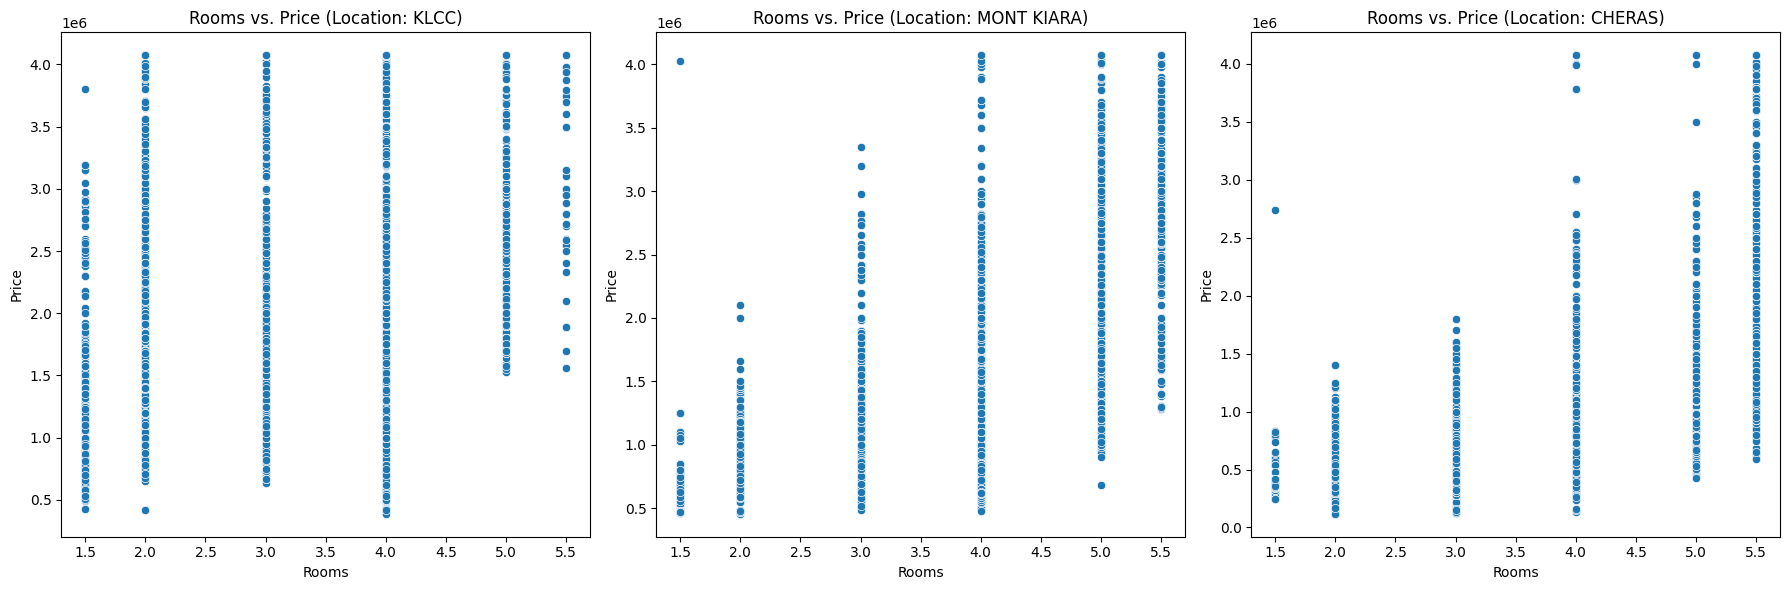

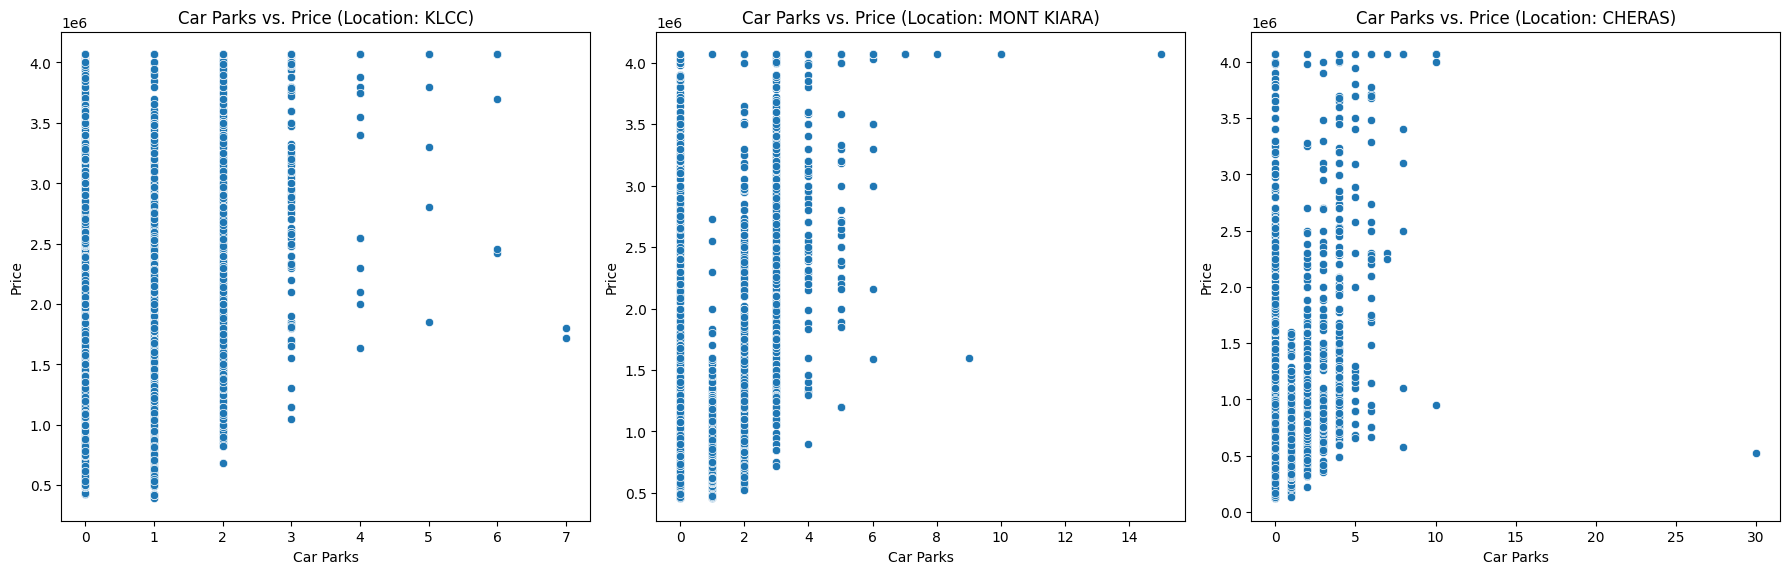

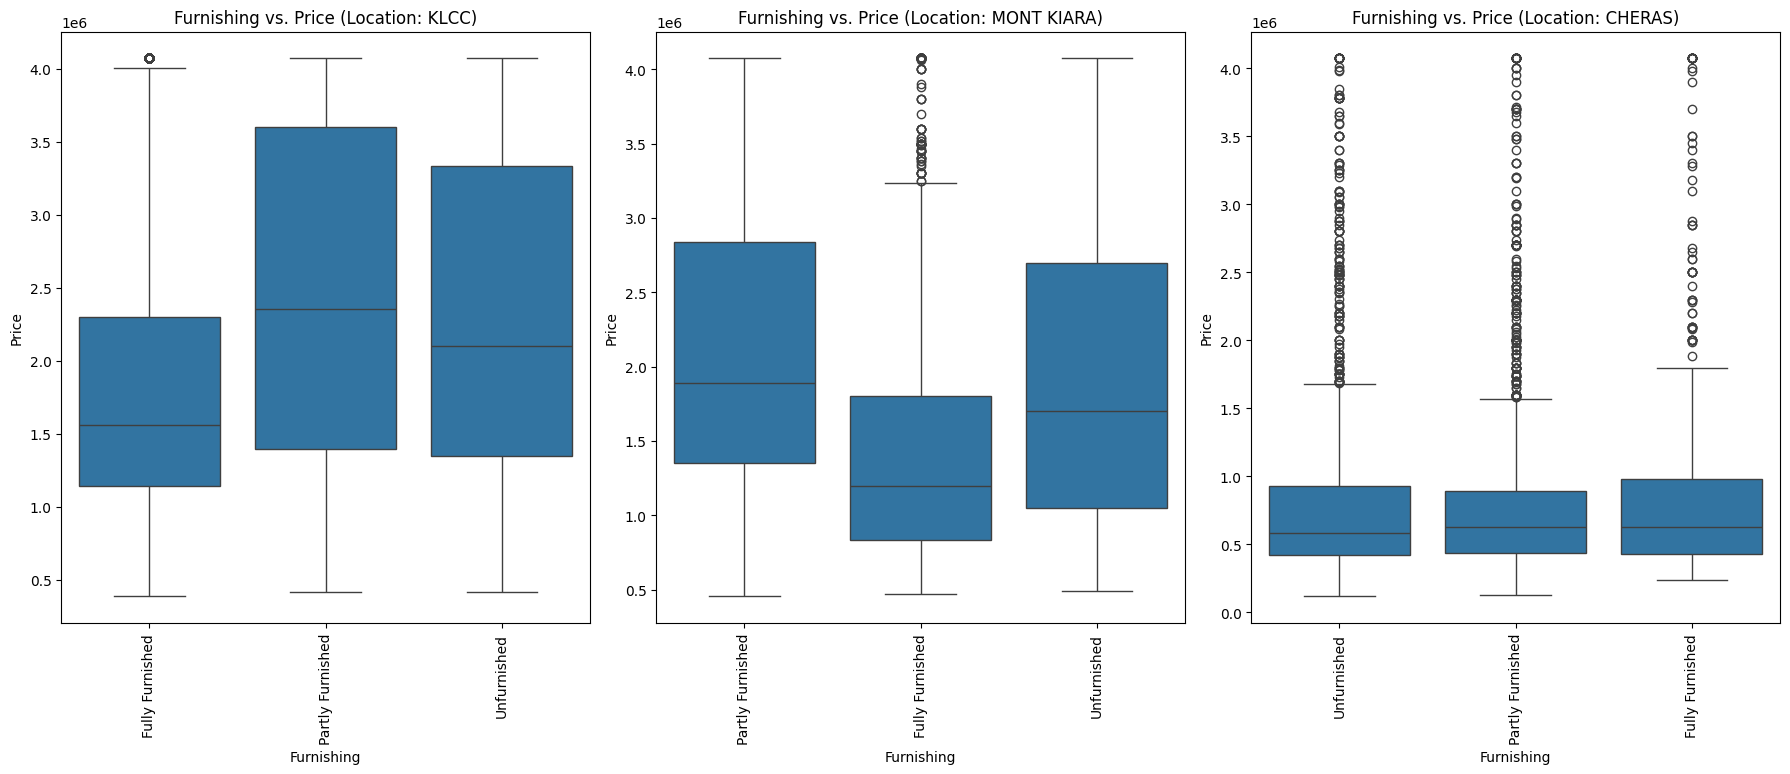

In [40]:
# Filter the data for the specific locations
df_klcc = df[df['Location'] == 'KLCC']
df_kiara = df[df['Location'] == 'MONT KIARA']
df_cheras = df[df['Location'] == 'CHERAS']

# Create a figure with three subplots for graph size vs. price
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Size vs. Price with Location = 'KLCC'
sns.scatterplot(ax=axs[0], x=df_klcc['Size'], y=df_klcc['Price'])
axs[0].set_title('Size vs. Price (Location: KLCC)')
axs[0].set_xlabel('Size')
axs[0].set_ylabel('Price')

# Scatter plot for Size vs. Price with Location = 'MONT KIARA'
sns.scatterplot(ax=axs[1], x=df_kiara['Size'], y=df_kiara['Price'])
axs[1].set_title('Size vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Size')
axs[1].set_ylabel('Price')

# Scatter plot for Size vs. Price with Location = 'CHERAS'
sns.scatterplot(ax=axs[2], x=df_cheras['Size'], y=df_cheras['Price'])
axs[2].set_title('Size vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Size')
axs[2].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Rooms vs. Price with Location = 'KLCC'
sns.scatterplot(ax=axs[0], x=df_klcc['Rooms'], y=df_klcc['Price'])
axs[0].set_title('Rooms vs. Price (Location: KLCC)')
axs[0].set_xlabel('Rooms')
axs[0].set_ylabel('Price')

# Scatter plot for Rooms vs. Price with Location = 'MONT KIARA'
sns.scatterplot(ax=axs[1], x=df_kiara['Rooms'], y=df_kiara['Price'])
axs[1].set_title('Rooms vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Rooms')
axs[1].set_ylabel('Price')

# Scatter plot for  vs. Price with Location = 'CHERAS'
sns.scatterplot(ax=axs[2], x=df_cheras['Rooms'], y=df_cheras['Price'])
axs[2].set_title('Rooms vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Rooms')
axs[2].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for Car Parks vs. Price with Location = 'KLCC'
sns.scatterplot(ax=axs[0], x=df_klcc['Car Parks'], y=df_klcc['Price'])
axs[0].set_title('Car Parks vs. Price (Location: KLCC)')
axs[0].set_xlabel('Car Parks')
axs[0].set_ylabel('Price')

# Scatter plot for Car Parks vs. Price with Location = 'MONT KIARA'
sns.scatterplot(ax=axs[1], x=df_kiara['Car Parks'], y=df_kiara['Price'])
axs[1].set_title('Car Parks vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Car Parks')
axs[1].set_ylabel('Price')

# Scatter plot for Car Parks vs. Price with Location = 'CHERAS'
sns.scatterplot(ax=axs[2], x=df_cheras['Car Parks'], y=df_cheras['Price'])
axs[2].set_title('Car Parks vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Car Parks')
axs[2].set_ylabel('Price')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Create a figure with three subplots for Furnihing vs Price for three selected three locations.
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

# Box plot for Furnishing vs. Price with Location = 'KLCC'
sns.boxplot(ax=axs[0], x=df_klcc['Furnishing'], y=df_klcc['Price'])
axs[0].set_title('Furnishing vs. Price (Location: KLCC)')
axs[0].set_xlabel('Furnishing')
axs[0].set_ylabel('Price')
axs[0].tick_params(axis='x', rotation=90)

# Box plot for Furnishing vs. Price with Location = 'MONT KIARA'
sns.boxplot(ax=axs[1], x=df_kiara['Furnishing'], y=df_kiara['Price'])
axs[1].set_title('Furnishing vs. Price (Location: MONT KIARA)')
axs[1].set_xlabel('Furnishing')
axs[1].set_ylabel('Price')
axs[1].tick_params(axis='x', rotation=90)

# Box plot for Furnishing vs. Price with Location = 'CHERAS'
sns.boxplot(ax=axs[2], x=df_cheras['Furnishing'], y=df_cheras['Price'])
axs[2].set_title('Furnishing vs. Price (Location: CHERAS)')
axs[2].set_xlabel('Furnishing')
axs[2].set_ylabel('Price')
axs[2].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


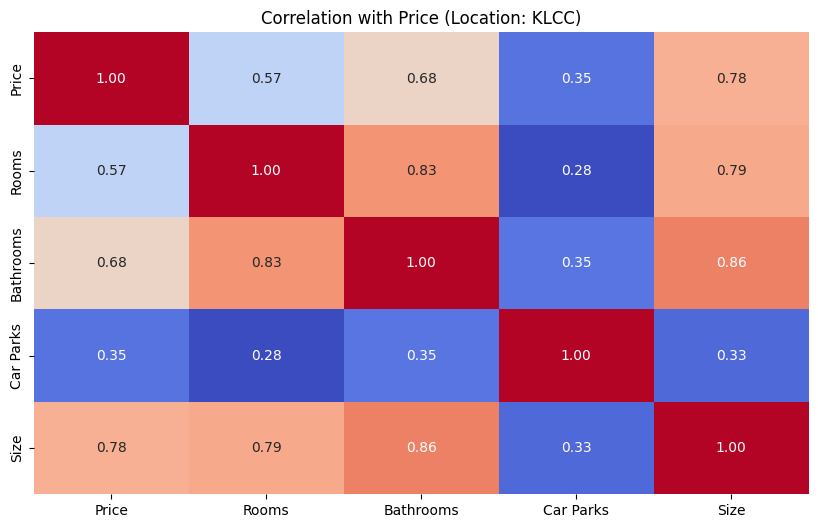

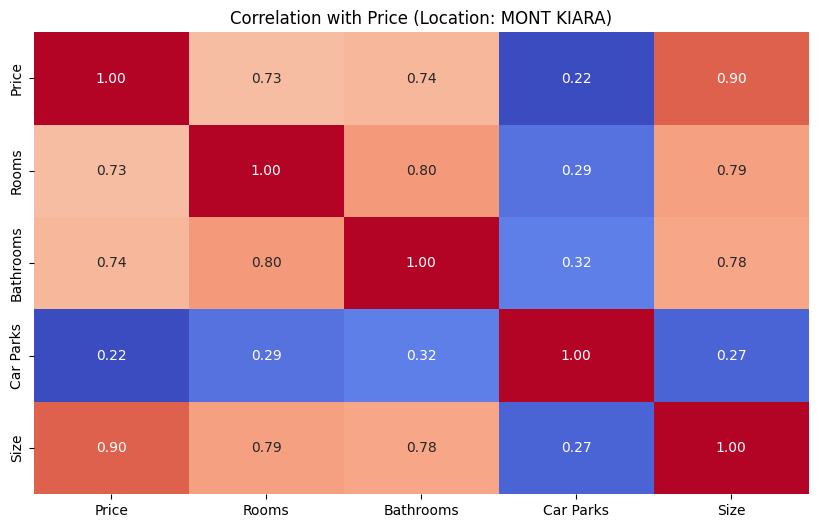

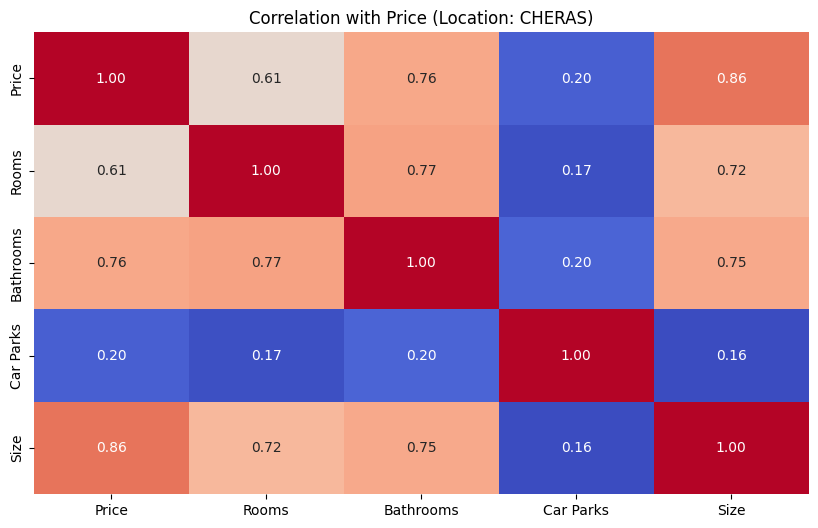

Correlation with Price (Location: KLCC):
               Price     Rooms  Bathrooms  Car Parks      Size
Price      1.000000  0.565293   0.684101   0.346925  0.776472
Rooms      0.565293  1.000000   0.830238   0.281449  0.789573
Bathrooms  0.684101  0.830238   1.000000   0.350178  0.860828
Car Parks  0.346925  0.281449   0.350178   1.000000  0.331362
Size       0.776472  0.789573   0.860828   0.331362  1.000000

Correlation with Price (Location: MONT KIARA):
               Price     Rooms  Bathrooms  Car Parks      Size
Price      1.000000  0.728240   0.742419   0.222040  0.900894
Rooms      0.728240  1.000000   0.804001   0.289537  0.792032
Bathrooms  0.742419  0.804001   1.000000   0.315841  0.780492
Car Parks  0.222040  0.289537   0.315841   1.000000  0.266066
Size       0.900894  0.792032   0.780492   0.266066  1.000000

Correlation with Price (Location: CHERAS):
               Price     Rooms  Bathrooms  Car Parks      Size
Price      1.000000  0.613041   0.759575   0.195613  0.859

In [41]:
# Filter the data for the specific locations
df_klcc = df[df['Location'] == 'KLCC']
df_kiara = df[df['Location'] == 'MONT KIARA']
df_cheras = df[df['Location'] == 'CHERAS']

# Calculate the correlation matrix for KLCC
corr_matrix_klcc = df_klcc[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()

# Plot the heatmap for KLCC
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_klcc, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Price (Location: KLCC)')
plt.show()

# Calculate the correlation matrix for MONT KIARA
corr_matrix_kiara = df_kiara[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()

# Plot the heatmap for MONT KIARA
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_kiara, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Price (Location: MONT KIARA)')
plt.show()

# Calculate the correlation matrix for CHERAS
corr_matrix_cheras = df_cheras[['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size']].corr()

# Plot the heatmap for CHERAS
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_cheras, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation with Price (Location: CHERAS)')
plt.show()

# Print the correlations with Price for each location
print("Correlation with Price (Location: KLCC):\n", corr_matrix_klcc)
print("\nCorrelation with Price (Location: MONT KIARA):\n", corr_matrix_kiara)
print("\nCorrelation with Price (Location: CHERAS):\n", corr_matrix_cheras)


In [42]:
from math import fabs 

train_test_score_diff = fabs(rf_model_train_score - rf_model_test_score)

# Print model performance metrics
print(f"Random Forest training score: {rf_model_train_score:.4f}")
print(f"Random Forest testing score: {rf_model_test_score:.4f}")
print(f"Difference between training and testing score: {train_test_score_diff:.4f}")
print(f"Random Forest Cross-Validation scores: {rf_cv_scores}")
print(f"Random Forest Cross-Validation Mean score: {np.mean(rf_cv_scores):.4f}")


Random Forest training score: 0.9832
Random Forest testing score: 0.9391
Difference between training and testing score: 0.0440
Random Forest Cross-Validation scores: [0.93928963 0.94050332 0.94113998 0.94333932 0.94150993]
Random Forest Cross-Validation Mean score: 0.9412


In [44]:
import scipy.stats as stats

top_location = df['Location'].value_counts()
top_location

MONT KIARA                           5660
KLCC                                 5037
CHERAS                               4262
JALAN KLANG LAMA (OLD KLANG ROAD)    2734
SETAPAK                              2571
                                     ... 
HAPPY GARDEN                            1
LANDED SD                               1
OFF GASING INDAH,                       1
TAMAN MELATI                            1
SERI KEMBANGAN                          1
Name: Location, Length: 102, dtype: int64

In [45]:
#Calculate t-test for means of 2 independent samples of scores
#Between prices and location

#Select prices of 2 top frequent locations
klcc_prices = df[df['Location'] == 'KLCC']['Price']
mont_prices = df[df['Location'] == 'MONT KIARA']['Price']

t_stat, p_value = stats.ttest_ind(klcc_prices, mont_prices)

#Print result of Test Statistic and P-value
print(f'Test Statistic: {t_stat}')
print(f'P-value: {p_value}')

print("\n")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0).")
    print("There is sufficient evidence to suggest that there is a relationship between Location and Price.")
else:
    print("Fail to reject the null hypothesis (H0).")
    print("There is not sufficient evidence to suggest that there is a relationship between Location and Price.")

Test Statistic: 14.08497809419795
P-value: 1.1764475540247569e-44


Reject the null hypothesis (H0).
There is sufficient evidence to suggest that there is a relationship between Location and Price.


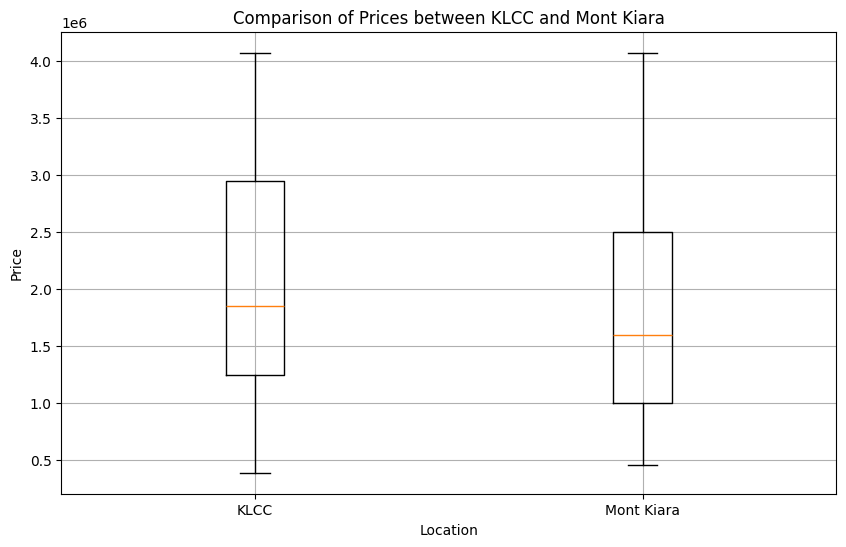

In [46]:
import matplotlib.pyplot as plt

# Create a box plot to compare prices between KLCC and Mont Kiara
plt.figure(figsize=(10, 6))
plt.boxplot([klcc_prices, mont_prices], tick_labels=['KLCC', 'Mont Kiara'])
plt.title('Comparison of Prices between KLCC and Mont Kiara')
plt.xlabel('Location')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [47]:
df['Property Type'].value_counts()

Condominium                   22426
Serviced Residence            12732
2-sty Terrace/Link House       4029
Bungalow                       3466
Semi-detached House            2091
3-sty Terrace/Link House       1629
Apartment                      1610
1-sty Terrace/Link House        791
2.5-sty Terrace/Link House      699
Residential Land                622
Townhouse                       531
Flat                            358
Name: Property Type, dtype: int64

In [48]:
#Create contingency table (cross-tabulation)
contingency_table = pd.crosstab(df['Property Type'], pd.cut(df['Price'], bins=3))

#Perform chi square test
chi_square, p_value, dof, expected = stats.chi2_contingency(contingency_table)

#Print result of Chi-square Statistic and P-value
print(f"Chi-square statistic: {chi_square}")
print(f"P-value: {p_value}")

print("\n")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0).")
    print("There is sufficient evidence to suggest that there is a relationship between Property Type and Price.")
else:
    print("Fail to reject the null hypothesis (H0).")
    print("There is not sufficient evidence to suggest that there is a relationship between Property Type and Price.")

Chi-square statistic: 21209.098450065776
P-value: 0.0


Reject the null hypothesis (H0).
There is sufficient evidence to suggest that there is a relationship between Property Type and Price.


([<matplotlib.axis.XTick at 0x20864f417b0>,
 [Text(0.5, 0, 'Low'), Text(1.5, 0, 'Medium'), Text(2.5, 0, 'High')])

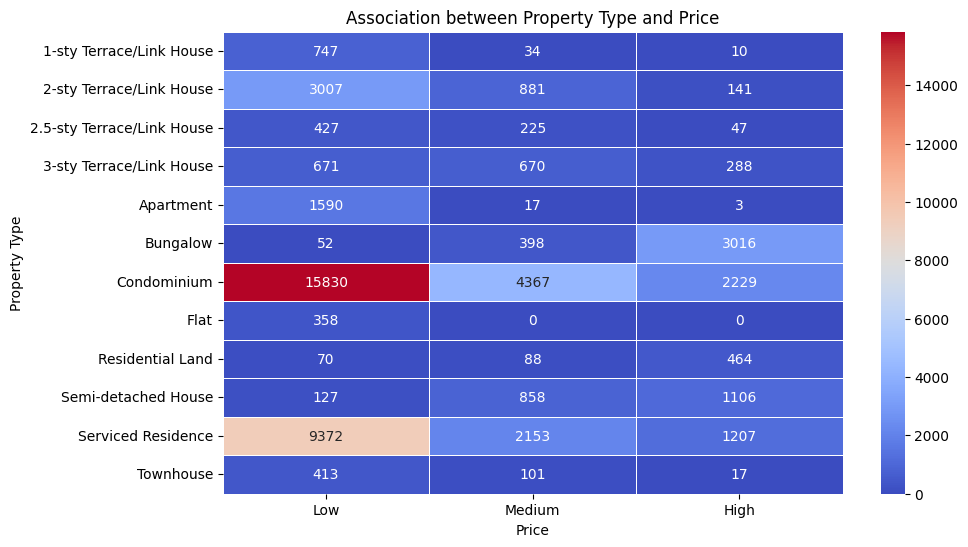

In [49]:
#Visualize using heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Association between Property Type and Price')
plt.xlabel('Price')
plt.ylabel('Property Type')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Low', 'Medium', 'High']) 

In [50]:
df['Furnishing'].value_counts()

Partly Furnished    25459
Fully Furnished     13208
Unfurnished         12317
Name: Furnishing, dtype: int64

In [51]:
#Group data by furnishing status
furnishing = [df[df['Furnishing'] == status]['Price'] for status in ['Partly Furnished', 'Fully Furnished', 'Unfurnished']]

#perform kruskal-wallis test
h_stat, p_value = stats.kruskal(*furnishing)

#Print result of kruskal-wallis h-statistic and P-value
print(f"Kruskal-Wallis H-statistic: {h_stat}")
print(f"P-value: {p_value}")

print("\n")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is sufficient evidence to suggest that there are differences in prices across different furnishing statuses.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not sufficient evidence to suggest that there are differences in prices across different furnishing statuses.")

Kruskal-Wallis H-statistic: 440.61032971862323
P-value: 2.1022413143322095e-96


Reject the null hypothesis.
There is sufficient evidence to suggest that there are differences in prices across different furnishing statuses.


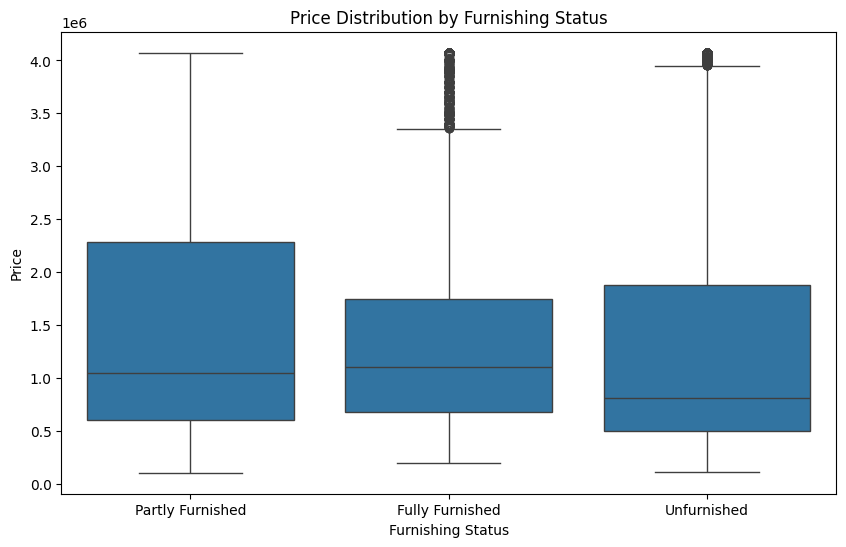

In [52]:
# Visualize using boxplots

plt.figure(figsize=(10, 6))
sns.boxplot(x='Furnishing', y='Price', data=df, order=['Partly Furnished', 'Fully Furnished', 'Unfurnished'])
plt.title('Price Distribution by Furnishing Status')
plt.xlabel('Furnishing Status')
plt.ylabel('Price')
plt.show()